In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from rich import print as pp
import json

In [2]:
def get_token_probs_per_layer(model, tokenizer, input_text, tokens_of_interest):
    
    inputs = tokenizer(input_text, return_tensors="pt")
    token_ids_of_interest = []

    for token in tokens_of_interest:
    
        token_id = tokenizer.encode(" " + token, add_special_tokens = False)[0]
        token_ids_of_interest.append(token_id)
    
    with torch.no_grad():
        
        op1 = model(**inputs,
                        output_hidden_states = True,
                        max_new_tokens = 3,
                        output_scores = True,
                        return_dict_in_generate = True,)
        
        op2 = model.generate(
        inputs.input_ids,
        max_new_tokens = 3,
        output_scores = True,
        return_dict_in_generate = True,)

    model_output = tokenizer.decode(op2[0][0])
    scores = op2.scores
    
    if hasattr(model, "lm_head"):
        output_projection = model.lm_head
    
    else:
        for name, module in model.named_modules():
            if any(x in name for x in ["lm_head", "output_projection", "score"]):
                output_projection = module
                break
    
    results = {'model_output': model_output,
               'layer_tkn_prob': [],
               'last_layer_atkn_prob': dict()}
    
    for layer_idx, layer_hidden_state in enumerate(op1.hidden_states):
    
        last_token_hidden = layer_hidden_state[0, -1, :]    
        logits = output_projection(last_token_hidden)
        probs = torch.softmax(logits, dim=-1)
        token_probs = {token: probs[token_id].item() 
                      for token, token_id in zip(tokens_of_interest, token_ids_of_interest)}
        
        results['layer_tkn_prob'].append((layer_idx, token_probs))
    
    for step, step_scores in enumerate(scores):
        
        probs = torch.softmax(step_scores, dim=-1)
        sorted_probs, sorted_ids = torch.topk(probs, k = 10, dim = -1)  # Top 10 tokens
        
        results['last_layer_atkn_prob'][f'token prob at postion {step+1}'] = []
        for prob, idx in zip(sorted_probs[0], sorted_ids[0]):
            results['last_layer_atkn_prob'][f'token prob at postion {step+1}'].append(f"{tokenizer.decode(idx)}: {prob.item():.4f}")
    
    return results

In [ ]:
model_names = ['microsoft/Phi-4-mini-instruct',
               'meta-llama/Llama-3.2-3B-Instruct',
               'google/gemma-3-4b-it',
               'Qwen/Qwen3-4B']

with open('./data/betl2train_with_s_a_id.json', 'r') as file_reader:
    betl2train = json.load(file_reader)

# model_name = 'microsoft/Phi-4-mini-instruct'
# model_name = 'meta-llama/Llama-3.2-3B-Instruct'
# model_name = 'google/gemma-3-4b-it'
model_name = 'Qwen/Qwen3-4B'

model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# for s_a_id, _ in track(betl2train.items(), description = "Processing samples"):
for s_a_id in betl2train:

    prompt = f'''You are an expert grader. You will be provided with a question, a set of reference answers which should be considered the golden standard, and a student's answer. Your task is to grade the student's answer as 'correct' or  'incorrect' based *only* on its semantic alignment with the reference answer. Output *only* the single word grade ('correct' or 'incorrect') and nothing else.\n\nQuestion: {betl2train[s_a_id]['q']}\n'''

    r_a = ""
    for i in range(len(betl2train[s_a_id]['r_a'])):
        r_a = r_a + f'''\nReference Answer {i + 1}: {betl2train[s_a_id]['r_a'][i]}\n'''
    
    prompt = prompt + r_a + f'''\nStudent Answer: {betl2train[s_a_id]['s_a']}\n\nGrade: '''

    tokens_to_check = ["correct", "incorrect", "Incorrect", "Correct"]
    results = get_token_probs_per_layer(model, tokenizer, prompt, tokens_to_check)

    print('MODEL OP: ', results['model_output'])

    for layer_idx, probs in results['layer_tkn_prob']:
        print(f"Layer {layer_idx}:")
        for token, prob in probs.items():
            print(f"  '{token}': {prob:.20f}")
        
    for position in results['last_layer_atkn_prob']:
        print(f'\n\nTop 10 probable token at output token postion {position}:')
        print(*results['last_layer_atkn_prob'][position], sep = '\n')
    
    break

/mnt/c/ayan/work/p2/conda_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


MODEL OP:  You are an expert grader. You will be provided with a question, a set of reference answers which should be considered the golden standard, and a student's answer. Your task is to grade the student's answer as 'correct' or  'incorrect' based *only* on its semantic alignment with the reference answer. Output *only* the single word grade ('correct' or 'incorrect') and nothing else.

Question: Explain why you got a voltage reading of 1.5 for terminal 1 and the positive terminal.

Reference Answer 1: Terminal 1 and the positive terminal are separated by the gap

Reference Answer 2: Terminal 1 and the positive terminal are not connected

Reference Answer 3: terminal 1 is connected to the negative battery terminal

Reference Answer 4: terminal 1 is not separated from the negative battery terminal

Reference Answer 5: Terminal 1 and the positive battery terminal are in different electrical states

Student Answer: positive battery terminal is separated by a gap from terminal 1

Grade

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from rich import print as pp
import json
from icecream import ic
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns


model_names = ['microsoft/Phi-4-mini-instruct',
               'meta-llama/Llama-3.2-3B-Instruct',
               'google/gemma-3-4b-it',
               'Qwen/Qwen3-4B']

with open('./data/betl2train_with_s_a_id.json', 'r') as file_reader:
    betl2train = json.load(file_reader)

with open('../hf_token.txt', 'r') as file_reader:
    hf_token = file_reader.readlines()[0]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = 'microsoft/Phi-4-mini-instruct'

model = AutoModelForCausalLM.from_pretrained(
    model_name, 
    device_map = device, 
    torch_dtype = "auto", 
    trust_remote_code = True,
    token = hf_token
)

tokenizer = AutoTokenizer.from_pretrained(model_name)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


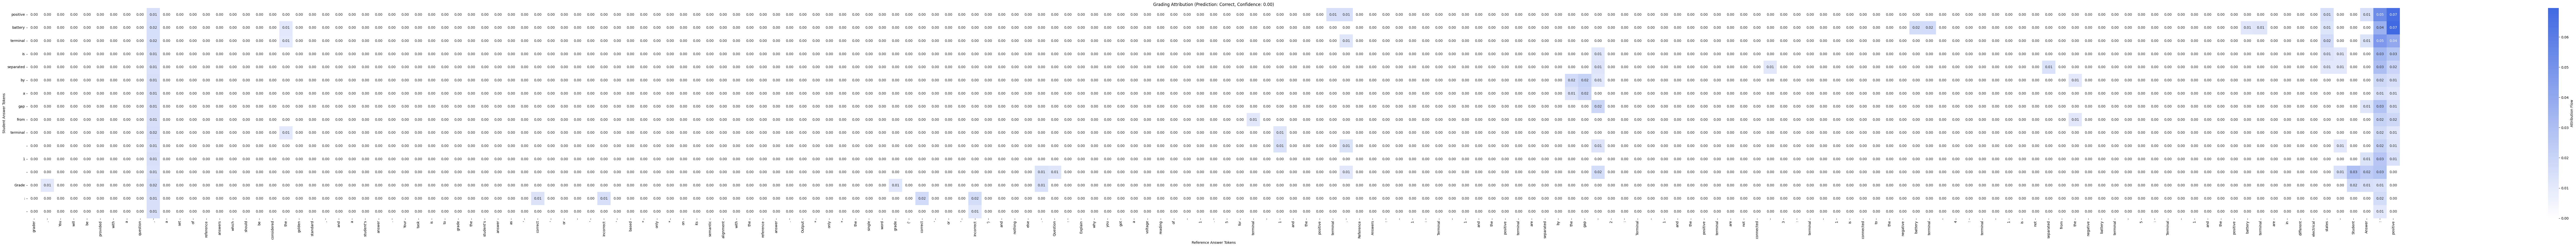

ic| sorted(important_connections, key = lambda x: x['flow'], reverse = True): [{'flow': 0.06956863403320312,
                                                                                'reference_token': 'positive',
                                                                                'student_token': 'battery'},
                                                                               {'flow': 0.06721878051757812,
                                                                                'reference_token': 'positive',
                                                                                'student_token': 'positive'},
                                                                               {'flow': 0.05328178405761719,
                                                                                'reference_token': ':',
                                                                                'student_token': 'positive'},
                  

In [3]:
for model_name in model_names:

    # model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states = True)

    # model = AutoModelForCausalLM.from_pretrained(
    #     model_name, 
    #     device_map = device, 
    #     torch_dtype = "auto", 
    #     trust_remote_code = True,
    #     token = hf_token
    # )

    # tokenizer = AutoTokenizer.from_pretrained(model_name)
    model.eval()

    # for s_a_id, _ in track(betl2train.items(), description = "Processing samples"):
    for s_a_id in betl2train:

        q = betl2train[s_a_id]['q']
        ref_a = betl2train[s_a_id]['r_a']
        st_a = betl2train[s_a_id]['s_a']
        
        prompt = f'''You are an expert grader. You will be provided with a question, a set of reference answers which should be considered the golden standard, and a student's answer. Your task is to grade the student's answer as 'correct' or  'incorrect' based *only* on its semantic alignment with the reference answer. Output *only* the single word grade ('correct' or 'incorrect') and nothing else.\n\nQuestion: {q}\n\nReference Answers : '''

        r_a = ""
        for i in range(len(ref_a)):
            r_a = r_a + f'''\n{i + 1}: {ref_a[i]}\n'''
        
        prompt = prompt + r_a + f'''\nStudent Answer: {st_a}\n\nGrade: '''

        # Tokenize
        inputs = tokenizer(prompt,
                           return_tensors = "pt",
                           truncation = True,).to(device)
                        #    return_offsets_mapping = True).to(device)
        
        # Get offset mapping with a separate tokenizer call
        encoding = tokenizer(prompt, return_offsets_mapping = True)

        # Track token positions
        all_tokens = [tokenizer.decode([id]) for id in inputs['input_ids'][0]]

        # Find section boundaries
        question_marker = "Question: "
        reference_marker = "Reference Answers: "
        student_marker = "Student Answer: "
        
        q_start = prompt.find(question_marker) + len(question_marker)
        ref_start = prompt.find(reference_marker) + len(reference_marker)
        student_start = prompt.find(student_marker) + len(student_marker)
        
        # Map tokens to sections
        token_map = {
            'question': [],
            'reference': [],
            'student': []
        }

        # Create byte-level position mapping
        # char_to_token = {}
        # for i, (id, offset) in enumerate(zip(inputs['input_ids'][0], inputs.offset_mapping[0])):
        #     if offset[1] > offset[0]:  # Skip special tokens with empty mapping
        #         for pos in range(offset[0], offset[1]):
        #             char_to_token[pos] = i
        
        char_to_token = {}
        for i, (start, end) in enumerate(encoding.offset_mapping):
            if end > start:  # Skip special tokens with empty mapping
                for pos in range(start, end):
                    char_to_token[pos] = i
        
        # ic(char_to_token)

        # Assign tokens to sections based on character position
        for char_pos in range(len(prompt)):
            if char_pos in char_to_token:
                token_idx = char_to_token[char_pos]
                if q_start <= char_pos < ref_start:
                    if token_idx not in token_map['question']:
                        token_map['question'].append(token_idx)
                elif ref_start <= char_pos < student_start:
                    if token_idx not in token_map['reference']:
                        token_map['reference'].append(token_idx)
                elif char_pos >= student_start:
                    if token_idx not in token_map['student']:
                        token_map['student'].append(token_idx)
        
        # return inputs, token_map, all_tokens

        
        # ic(inputs)
        # ic(token_map)
        # ic(tokens)

        with torch.no_grad():
            outputs = model(**inputs, output_attentions = True)

        attentions = outputs.attentions  # List of attention tensors (one per layer)
        logits = outputs.logits[:, -1, :]

        # ic(attentions)

            
        cross_attentions = []
        
        for layer_idx, layer_attention in enumerate(attentions):
            # Average across attention heads
            layer_attn = layer_attention.mean(dim = 1).squeeze(0)  # Shape: [seq_len, seq_len]
            
            # Extract student→reference attention submatrix
            student_indices = token_map['student']
            reference_indices = token_map['reference']
            
            # Build cross-attention matrix for this layer
            cross_attn_matrix = torch.zeros(
                (len(student_indices), len(reference_indices)),
                device = layer_attn.device
            )
            
            for i, s_idx in enumerate(student_indices):
                for j, r_idx in enumerate(reference_indices):
                    cross_attn_matrix[i, j] = layer_attn[s_idx, r_idx]
            
            cross_attentions.append(cross_attn_matrix)

        # return cross_attentions, logits


        # # ic(cross_attentions)
        # # ic(outputs.logits)

        # logits = outputs.logits
        # probs = torch.softmax(logits, dim=1)
        # pred_class = torch.argmax(probs, dim=1).item()
        # confidence = probs[0, pred_class].item()
        # prediction = "Correct" if pred_class == 1 else "Incorrect"
        
        # # Get relevant tokens
        # student_tokens = [all_tokens[idx] for idx in token_map['student']]
        # reference_tokens = [all_tokens[idx] for idx in token_map['reference']]

        # Focus on student→reference attention
        
        pos_tokens = ["correct", "right", "yes", "Correct", "1"]
        neg_tokens = ["incorrect", "wrong", "no", "Incorrect", "0"] 
        
        # Get average probability for positive and negative tokens
        probs = torch.softmax(logits, dim =-1)
        
        pos_ids = [tokenizer.encode(t, add_special_tokens=False)[0] for t in pos_tokens 
                    if len(tokenizer.encode(t, add_special_tokens=False)) > 0]
        neg_ids = [tokenizer.encode(t, add_special_tokens=False)[0] for t in neg_tokens
                    if len(tokenizer.encode(t, add_special_tokens=False)) > 0]
        
        pos_prob = sum(probs[0, id].item() for id in pos_ids) / len(pos_ids) if pos_ids else 0
        neg_prob = sum(probs[0, id].item() for id in neg_ids) / len(neg_ids) if neg_ids else 0
        
        if pos_prob > neg_prob:
            prediction = "Correct"
            pred_class = 1
            confidence = pos_prob
        else:
            prediction = "Incorrect"
            pred_class = 0
            confidence = neg_prob
        
        # return prediction, pred_class, confidence
        # ic(prediction)
        # ic(pred_class)
        # ic(confidence)
        
        # Get relevant tokens
        student_tokens = [all_tokens[idx] for idx in token_map['student']]
        reference_tokens = [all_tokens[idx] for idx in token_map['reference']]


        avg_attn = torch.mean(torch.stack(cross_attentions), dim = 0)
        
        # Build flow network
        G = nx.DiGraph()
        
        # Add source and sink nodes
        G.add_node('source')
        G.add_node('sink')
        
        # Add student and reference token nodes
        for i in range(len(student_tokens)):
            G.add_node(f's_{i}')
            # Connect source to student tokens
            G.add_edge('source', f's_{i}', capacity = 1.0)
            
        for j in range(len(reference_tokens)):
            G.add_node(f'r_{j}')
            # Connect reference tokens to sink
            G.add_edge(f'r_{j}', 'sink', capacity = 1.0)
            
        # Add edges between student and reference tokens based on attention
        for i in range(len(student_tokens)):
            for j in range(len(reference_tokens)):
                attention_weight = avg_attn[i, j].item()
                if attention_weight > 0.01:  # Threshold to reduce complexity
                    G.add_edge(f's_{i}', f'r_{j}', capacity = attention_weight)
        
        # Compute maximum flow
        flow_value, flow_dict = nx.maximum_flow(G, 'source', 'sink')
        
        # Extract flow values
        flow_matrix = torch.zeros_like(avg_attn)
        for i in range(len(student_tokens)):
            s_node = f's_{i}'
            if s_node in flow_dict:
                for j in range(len(reference_tokens)):
                    r_node = f'r_{j}'
                    if r_node in flow_dict[s_node]:
                        flow_matrix[i, j] = flow_dict[s_node][r_node]
        
        # return flow_matrix

        filename = "attribution_heatmap.png"

        clean_student = [t.replace('Ġ', ' ').strip() for t in student_tokens]
        clean_reference = [t.replace('Ġ', ' ').strip() for t in reference_tokens]
        
        plt.figure(figsize = (120, 10))
        
        # Create custom colormap
        cmap = LinearSegmentedColormap.from_list('blue_gradient', ['white', 'royalblue'])
        
        sns.heatmap(
            flow_matrix.detach().cpu().numpy(),
            xticklabels = clean_reference,
            yticklabels = clean_student,
            cmap = cmap,
            annot = True,
            fmt = ".2f",
            cbar_kws = {'label': 'Attribution Flow'}
        )
        
        plt.xlabel('Reference Answer Tokens')
        plt.ylabel('Student Answer Tokens')
        plt.title(f'Grading Attribution (Prediction: {prediction}, Confidence: {confidence:.2f})')
        plt.tight_layout()
        
        # if filename:
        #     plt.savefig('results/test1.png')
        plt.savefig('results/test1.png')

        
        plt.show()
        
        # Return the most important connections
        important_connections = []
        for i in range(len(student_tokens)):
            for j in range(len(reference_tokens)):
                if flow_matrix[i, j] > 0.00001:
                    important_connections.append({
                        'student_token': clean_student[i],
                        'reference_token': clean_reference[j],
                        'flow': flow_matrix[i, j].item()
                    })
        
        ic(sorted(important_connections, key = lambda x: x['flow'], reverse = True))











        break
    break

In [8]:
torch.set_printoptions(threshold=1000000)
pp(flow_matrix)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0145, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0147,
         0.0142, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0147, 0.0000, 0.0000, 0.0145, 0.0533, 0.0672],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0151, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0101, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0159, 0.0162,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0111, 0.0119, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0124, 0.0000, 0.0000, 0.0000, 0.0367, 0.0696],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0151, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0100, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.00

In [3]:
inputs['input_ids'][0].shape

torch.Size([207])

In [9]:
ic(inputs.keys())#.offset_mapping[0]

ic| inputs.keys(): dict_keys(['input_ids', 'attention_mask', 'offset_mapping'])


dict_keys(['input_ids', 'attention_mask', 'offset_mapping'])

In [8]:
inputs = tokenizer(prompt, return_tensors = "pt", truncation = True, return_offsets_mapping = True)